# 17기 Clustering 정규세션 과제

## Clustering 해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. Clustering 
수업 내용 및 실습 자료를 참고하여 클러스터링을 자유롭게 진행해주세요. 한 알고리즘에 대해 파라미터를 바꿔가며 비교를 해도 되고, 여러 알고리즘의 결과를 비교해도 됩니다.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [Mall Customer Segmentation Data| Kaggle](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

---

### 데이터 불러오기

In [46]:
import pandas as pd
df = pd.read_csv("Mall_Customers.csv", index_col = 0)
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


### 모듈 불러오기

In [47]:
# 데이터 전처리
import numpy as np
import pandas as pd

# 기계학습 모델(군집화) 생성, 학습, 평가
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# 시각화 & 편의용
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['axes.unicode_minus'] = False

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')

위의 데이터에서 Gender를 구해내는 Clustering을 만들겠다.

([<matplotlib.patches.Wedge at 0x7f929aee2490>,
 [Text(-0.20611945413751356, 1.080515974257694, 'Female'),
  Text(0.20611945413751365, -1.080515974257694, 'Male')])

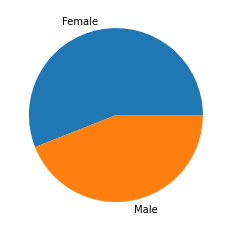

In [48]:
# Target label 분포
target_label_count = df['Gender'].value_counts()
plt.pie(target_label_count, labels = target_label_count.index)

#Data의 Female의 비율이 조금 더 높긴 하지만, 크게 차이나지 않는다.

<AxesSubplot:>

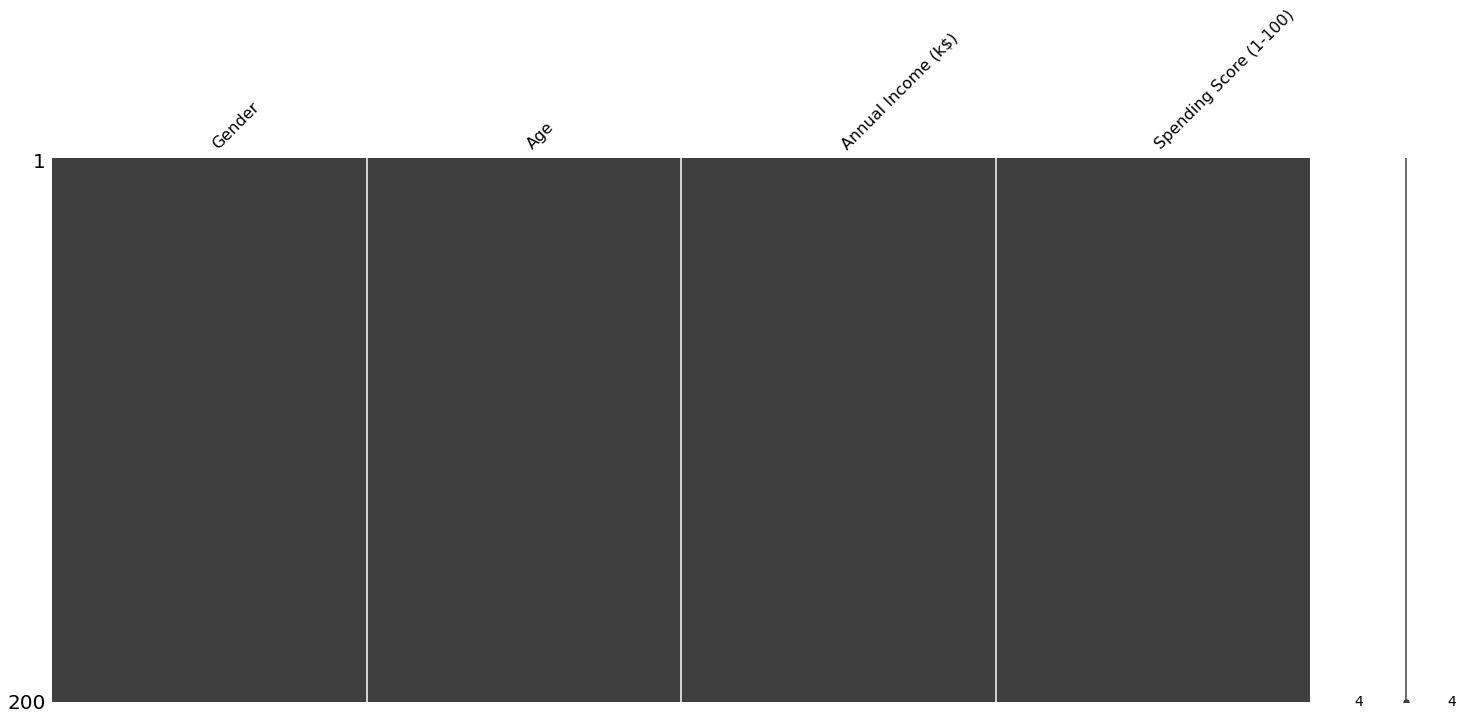

In [49]:
import missingno as msno

msno.matrix(df)

In [50]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [51]:
df.isnull().sum()
#null없이 꽉 차있는 값이다. null값 처리가 필요 없다.

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## EDA

In [52]:
df.describe(include='all')

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200,200.000000,200.000000,200.000000
unique,2,NaN,NaN,NaN
top,Female,NaN,NaN,NaN
freq,112,NaN,NaN,NaN
mean,NaN,38.850000,60.560000,50.200000
std,NaN,13.969007,26.264721,25.823522
min,NaN,18.000000,15.000000,1.000000
25%,NaN,28.750000,41.500000,34.750000
50%,NaN,36.000000,61.500000,50.000000
75%,NaN,49.000000,78.000000,73.000000


In [53]:
df.info() #Gender는 범주형 / 그 이외는 수치형 변수이다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [54]:
for value in df:
    print("================================")
    print(value)
    print("================================")
    print(df[value].value_counts())

Gender
Female    112
Male       88
Name: Gender, dtype: int64
Age
32    11
35     9
31     8
19     8
30     7
49     7
40     6
38     6
36     6
47     6
23     6
27     6
20     5
48     5
21     5
34     5
50     5
29     5
28     4
24     4
54     4
67     4
59     4
18     4
68     3
60     3
46     3
43     3
45     3
22     3
25     3
39     3
37     3
33     3
58     2
66     2
65     2
63     2
26     2
57     2
44     2
53     2
52     2
51     2
41     2
42     2
70     2
56     1
55     1
64     1
69     1
Name: Age, dtype: int64
Annual Income (k$)
54     12
78     12
48      6
71      6
63      6
       ..
58      2
59      2
16      2
64      2
137     2
Name: Annual Income (k$), Length: 64, dtype: int64
Spending Score (1-100)
42    8
55    7
46    6
73    6
75    5
     ..
63    1
34    1
44    1
45    1
99    1
Name: Spending Score (1-100), Length: 84, dtype: int64


- 예측1) Annual Income과 Spending Score의 상관관계는 매우 높을 것이다.
- 예측2) Age와 Spending Score의 상관관계는 매우 높을 것이다.

In [55]:
import pandas as pd
import pandas_profiling
pr = df.profile_report()
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [56]:
num_feature = ['Annual Income (k$)','Age', 'Spending Score (1-100)']
num_cols_data_cor = df[num_feature].corr()
num_cols_data_cor

,Annual Income (k$),Age,Spending Score (1-100)
Annual Income (k$),1.000000,-0.012398,0.009903
Age,-0.012398,1.000000,-0.327227
Spending Score (1-100),0.009903,-0.327227,1.000000


In [64]:
df.columns

Index(['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

<AxesSubplot:>

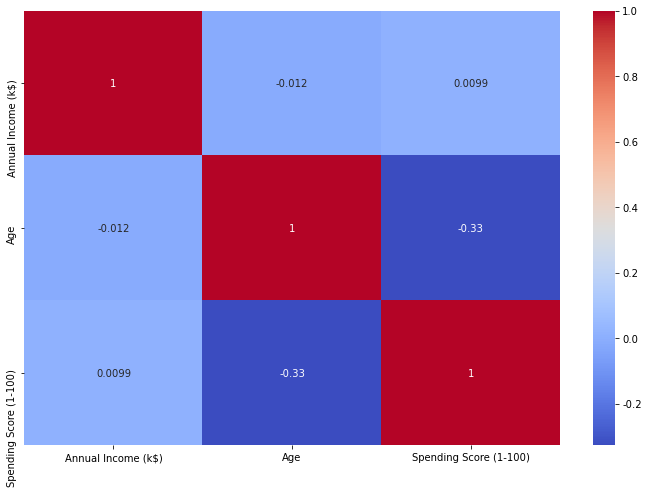

In [65]:
plt.figure(figsize=(12,8))

sns.heatmap(num_cols_data_cor,cmap='coolwarm', annot=True)

<AxesSubplot:ylabel='Density'>

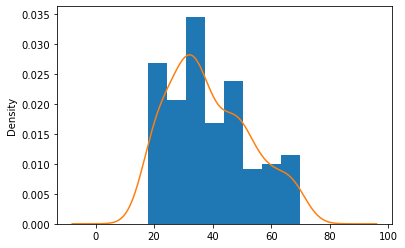

In [66]:
#Age
plt.hist(df['Age'], bins='fd', density=True)
df['Age'].plot.density()

#종모양의 정규분포 이루고 있음.

In [67]:
# !pip install plotnine

<ggplot: (8766729022105)>

<Figure size 432x288 with 0 Axes>

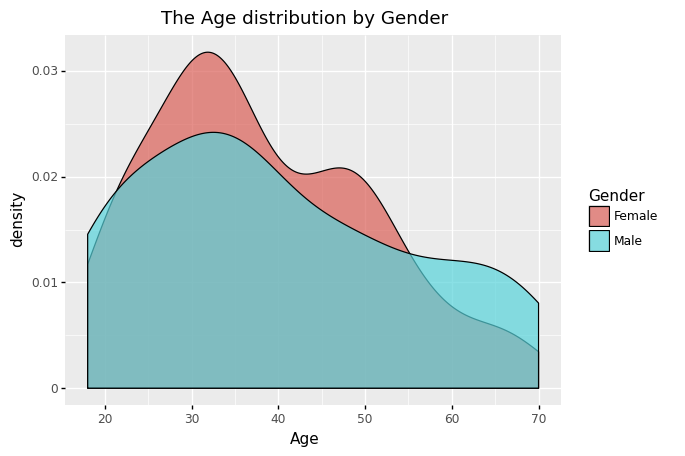

In [68]:
from plotnine import * #성별과 나이의 관계 보기 
fig = plt.figure()

ggplot(df, aes(x='Age', fill='Gender')) + geom_density(alpha=0.7) + ggtitle("The Age distribution by Gender")
#여자가 더 어린 분포를 가지고 있음

<ggplot: (8766729016841)>

<Figure size 432x288 with 0 Axes>

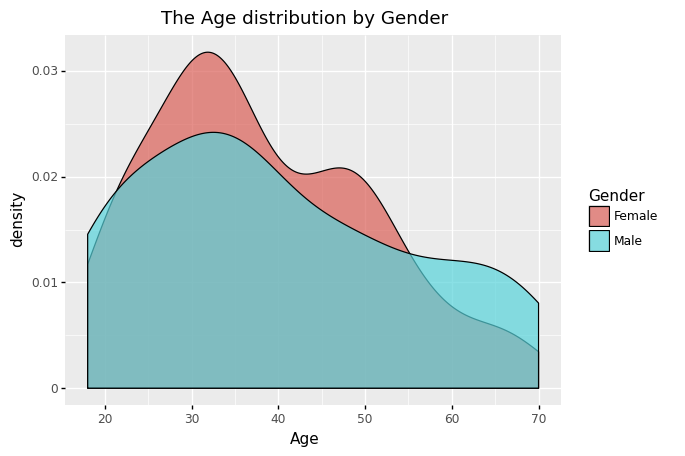

In [69]:
from plotnine import * #성별과 나이의 관계 보기 
fig = plt.figure()

ggplot(df, aes(x='Age', fill='Gender')) + geom_density(alpha=0.7) + ggtitle("The Age distribution by Gender")
#여자가 더 어린 분포를 가지고 있음

<ggplot: (8766732957165)>

<Figure size 432x288 with 0 Axes>

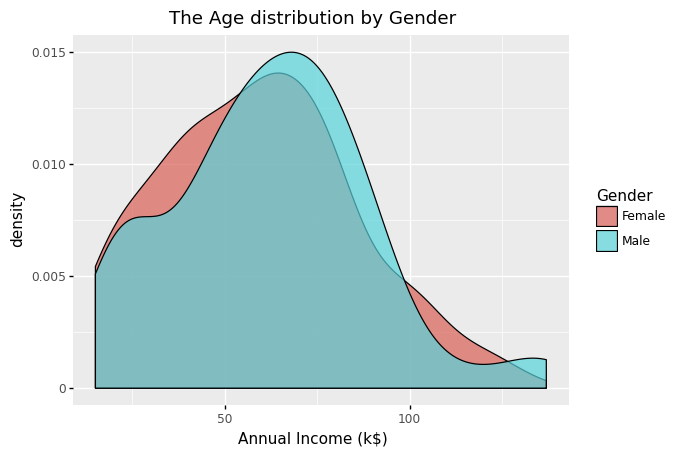

In [70]:
from plotnine import * #성별과 수입의 관계 보기 
fig = plt.figure()

ggplot(df, aes(x='Annual Income (k$)', fill='Gender')) + geom_density(alpha=0.7) + ggtitle("The Age distribution by Gender")
#분포는 다르지만 큰 차이는 없음

<ggplot: (8766732176349)>

<Figure size 432x288 with 0 Axes>

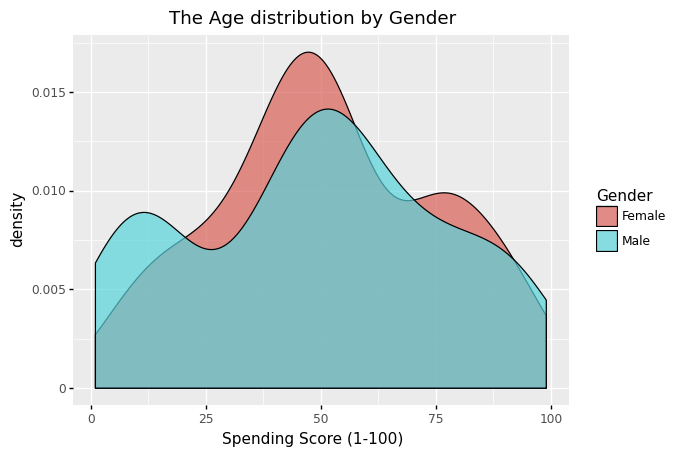

In [71]:
from plotnine import * #성별과 소비지수 관계 보기 
fig = plt.figure()

ggplot(df, aes(x='Spending Score (1-100)', fill='Gender')) + geom_density(alpha=0.7) + ggtitle("The Age distribution by Gender")
#분포는 다르지만 큰 차이는 없음

# Clustering

## Hierarchical Clustering 모델 정의
+ Linkage: complete(max)
+ Distance: euclidean
+ Threshold: 5
+ 계층적 트리모형을 이용하여 개별 개체들을 순차적/계층적으로 유사한 개체/ 군집과 통합한다.

Threshold: 덴드로그램의 y축에서 군집을 나누는 기준이 된다.밑에 덴드로그램 그려보기에서 threshold 값을 바꿔가며 비교해보자.

In [78]:
# 모델 정의
model = AgglomerativeClustering(
    linkage='complete',
    affinity='euclidean',
    distance_threshold=5,
    n_clusters=None)

# 학습
blobs_clusters = model.fit_predict(blobs_x)

NameError: name 'blobs_x' is not defined

##  K-MEANS Clustering 모델 정의
+ 대표적인 분리형 군집화 알고리즘
+ 각 군집은 하나의 중심을 가진다.
+ 각 개체는 가장 가까운 중심에 할당되며, 같은 중심에 할당된 개체들이 모여 하나의 군집을 형성한다.
+ 사전에 군집의 수 K가 정해져야 알고리즘을 실행할 수 있다.

## DBSCAN
+ 공간상에 높은 밀도를 가지고 모여 있는 관측치들을 하나의 그룹으로 간주하고 낮은 밀도를 가지고 홀로 있는 관측치는 이상치 또는 잡음으로 분류하는 밀도 기반 군집화 알고리즘
+ 클러스터의 개수를 미리 지정할 필요가 없다. 
+ 복잡한 형상도 찾을 수 있으며, 어떤 클래스에도 속하지 않는 포인트를 구분할 수 있다.